In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

class BacktestCrossMA:
    def __init__(self) -> None:
        self.df = pd.DataFrame()
        self.days = []
        self.trades = []

    def load_data(self, path):
        self.df = pd.read_csv(path)
        self.df["date"] = pd.to_datetime(self.df["date"], unit="ms")
        self.df = self.df.set_index(self.df["date"])
        del self.df["date"]

    def populate_indicators(self):
        self.df['ma50'] = self.df['close'].rolling(50).mean()
        self.df['ma200'] = self.df['close'].rolling(200).mean()

    def populate_signals(self):
        self.df['buy_signal'] = self.df['ma50'] > self.df['ma200']
        self.df['sell_signal'] = self.df['ma50'] < self.df['ma200']

    def run_backtest(self):
        balance = 1000
        position = None
        fee = 0.001
        previous_day = -1

        self.days = []
        self.trades = []

        for index, row in self.df.iterrows():

            # ★ DAILY SNAPSHOT ★
            current_day = index.day
            if previous_day != current_day:
                temp_balance = balance
                
                if position:  # mark-to-market
                    close_price = row['close']
                    r = (close_price - position['open_price']) / position['open_price']
                    close_size = position['open_size'] * (1 + r)
                    close_size -= close_size * fee
                    temp_balance = balance + (close_size - position['open_size'])

                self.days.append({
                    "day": index.date(),
                    "balance": temp_balance,
                    "price": row["close"]
                })

            previous_day = current_day

            # ============================================
            # ★ STOP LOSS LOGIC (AFTER 1 CANDLE DELAY) ★
            # ============================================
            if position and position["allow_stoploss"]:
                if row["low"] <= position['stop_loss']:

                    close_price = position['stop_loss']
                    r = (close_price - position['open_price']) / position['open_price']
                    close_size = position["open_size"] * (1 + r)
                    fee_sl = close_size * fee
                    close_size -= fee_sl

                    balance += close_size - position["open_size"]

                    self.trades.append({
                        "open_date": position["open_date"],
                        "close_date": index,
                        "open_price": position["open_price"],
                        "close_price": close_price,
                        "open_size": position["open_size"],
                        "close_size": close_size,
                        "open_fee": position["open_fee"],
                        "close_fee": fee_sl,
                        "open_reason": "Market Buy",
                        "close_reason": "stop_loss",
                        "open_balance": position["open_balance"],
                        "close_balance": balance,
                    })

                    position = None
                    print(f"{index} - STOP LOSS at {close_price}, balance={balance:.2f}")
                    continue

            # ===================
            # ★ SELL LOGIC ★
            # ===================
            if position and row["sell_signal"]:
                close_price = row["close"]
                r = (close_price - position["open_price"]) / position["open_price"]
                close_size = position["open_size"] * (1 + r)
                fee_sell = close_size * fee
                close_size -= fee_sell

                balance += close_size - position["open_size"]

                self.trades.append({
                    "open_date": position["open_date"],
                    "close_date": index,
                    "open_price": position["open_price"],
                    "close_price": close_price,
                    "open_size": position["open_size"],
                    "close_size": close_size,
                    "open_fee": position["open_fee"],
                    "close_fee": fee_sell,
                    "open_reason": "Market Buy",
                    "close_reason": "sell_signal",
                    "open_balance": position["open_balance"],
                    "close_balance": balance,
                })

                position = None
                print(f"{index} - SELL at {close_price}, balance={balance:.2f}")
                continue

            # ==============
            # ★ BUY LOGIC ★
            # ==============
            if (position is None) and row["buy_signal"]:
                open_price = row["close"]
                open_size = balance
                fee_buy = open_size * fee
                open_size -= fee_buy
                balance -= fee_buy

                stop_loss_price = open_price * (1 - 0.10)  # 10% stop loss

                position = {
                    "open_price": open_price,
                    "open_size": open_size,
                    "open_date": index,
                    "open_fee": fee_buy,
                    "open_balance": balance,
                    "stop_loss": stop_loss_price,
                    "allow_stoploss": False,   # *** FIX ***
                }

                print(f"{index} - BUY at {open_price}, balance={balance:.2f}")
                continue

            # =============
            # ★ ACTIVATE SL AFTER ONE CANDLE ★
            # =============
            if position and not position["allow_stoploss"]:
                position["allow_stoploss"] = True

        print(f"Final Balance: {balance}")
        
    def backtest_analaysis(self):
        df_days = pd.DataFrame(self.days)
        df_trades = pd.DataFrame(self.trades)

        if df_days.empty: raise ValueError("No days found")
        if df_trades.empty: raise ValueError("No trades found")

        df_days['evolution'] = df_days['balance'].diff()
        df_days['daily_returns'] = df_days['balance'].pct_change()

        df_trades["trade_result"] = df_trades["close_size"] - df_trades["open_size"]
        df_trades["trade_result_pct"] = df_trades["trade_result"] / df_trades["open_size"]
        df_trades["trades_duration"] = df_trades["close_date"] - df_trades["open_date"]

        self.df_days = df_days
        self.df_trades = df_trades

        df_days["balance_ath"] = df_days["balance"].cummax()
        df_days["drawdown"] = df_days["balance_ath"] - df_days["balance"]
        df_days["drawdown_pct"] = df_days["drawdown"] / df_days["balance_ath"]

        self.df_days = df_days
        self.df_trades = df_trades
        return df_days, df_trades
    
    def plot_equity_vs_asset(self):
        df_days = self.df_days.copy().set_index("day")

        fig, ax_left = plt.subplots(figsize=(20, 15), nrows=4, ncols=1)

        # ==========================================================
        # 1. EQUITY CURVE
        # ==========================================================
        ax_left[0].set_title("Equity Curve (Portfolio Value Over Time)", fontsize=14, fontweight='bold')
        ax_left[0].plot(df_days.index, df_days['balance'], color='royalblue', lw=1.5, label='Balance')
        ax_left[0].fill_between(df_days.index, df_days['balance'], alpha=0.15, color='royalblue')
        ax_left[0].axhline(y=df_days['balance'].iloc[0], color='grey', alpha=0.4, ls='--')
        ax_left[0].legend(loc="upper left")
        ax_left[0].set_ylabel("Balance ($)", fontsize=12)

        # ==========================================================
        # 2. ASSET PRICE CURVE
        # ==========================================================
        ax_left[1].set_title("Asset Price (BTC)", fontsize=14, fontweight='bold')
        ax_left[1].plot(df_days.index, df_days['price'], color='sandybrown', lw=1.5, label='BTC Price')
        ax_left[1].fill_between(df_days.index, df_days['price'], alpha=0.15, color='sandybrown')
        ax_left[1].axhline(y=df_days['price'].iloc[0], color='grey', alpha=0.4, ls='--')
        ax_left[1].legend(loc="upper left")
        ax_left[1].set_ylabel("Price ($)", fontsize=12)

        # ==========================================================
        # 3. DRAWDOWN CURVE
        # ==========================================================
        ax_left[2].set_title("Drawdown (%)", fontsize=14, fontweight='bold')
        ax_left[2].plot(df_days.index, -df_days['drawdown_pct']*100, color='indianred', lw=1.5, label='Drawdown')
        ax_left[2].fill_between(df_days.index, -df_days['drawdown_pct']*100, alpha=0.15, color='indianred')
        ax_left[2].axhline(y=0, color='grey', alpha=0.4, ls='--')
        ax_left[2].legend(loc="lower left")
        ax_left[2].set_ylabel("Drawdown (%)", fontsize=12)

        # ==========================================================
        # 4. PnL vs PRICE (Twin Axes)
        # ==========================================================
        ax_left[3].set_title("PnL vs Asset Price (Separate Scales)", fontsize=14, fontweight='bold')

        # PnL curve (left axis)
        pnl = df_days['balance'] - df_days['balance'].iloc[0]
        ax_left[3].plot(df_days.index, pnl, color='royalblue', lw=1.5, label='PnL ($)')
        ax_left[3].set_ylabel("PnL ($)", fontsize=12)

        # Price curve (right axis)
        ax_right = ax_left[3].twinx()
        ax_right.plot(df_days.index, df_days['price'], color='sandybrown', lw=1.5, label='BTC Price')
        ax_right.set_ylabel("Price ($)", fontsize=12)

        # Legends
        ax_left[3].legend(loc="lower right")
        ax_right.legend(loc="upper left")

        # ==========================================================
        plt.tight_layout()
        plt.show()



2017-08-25 11:00:00 - BUY at 4361.27, balance=999.00
2017-09-04 06:00:00 - SELL at 4459.77, balance=1020.54
2017-09-07 21:00:00 - BUY at 4641.13, balance=1019.52
2017-09-08 14:00:00 - STOP LOSS at 4177.017, balance=916.65
2017-09-08 15:00:00 - BUY at 4348.65, balance=915.73
2017-09-09 13:00:00 - SELL at 4300.16, balance=904.62
2017-09-19 09:00:00 - BUY at 3940.2, balance=903.71
2017-09-22 11:00:00 - STOP LOSS at 3546.18, balance=812.53
2017-09-22 12:00:00 - BUY at 3592.12, balance=811.72
2017-09-22 21:00:00 - SELL at 3624.21, balance=818.15
2017-09-26 13:00:00 - BUY at 3928.33, balance=817.33
2017-10-05 07:00:00 - SELL at 4154.1, balance=863.44
2017-10-06 17:00:00 - BUY at 4336.16, balance=862.58
2017-10-19 19:00:00 - SELL at 5609.0, balance=1114.66
2017-10-20 15:00:00 - BUY at 5889.99, balance=1113.55
2017-10-25 02:00:00 - STOP LOSS at 5300.991, balance=1001.19
2017-10-27 21:00:00 - BUY at 5769.6, balance=1000.19
2017-10-28 17:00:00 - SELL at 5700.37, balance=987.20
2017-10-29 21:00:0

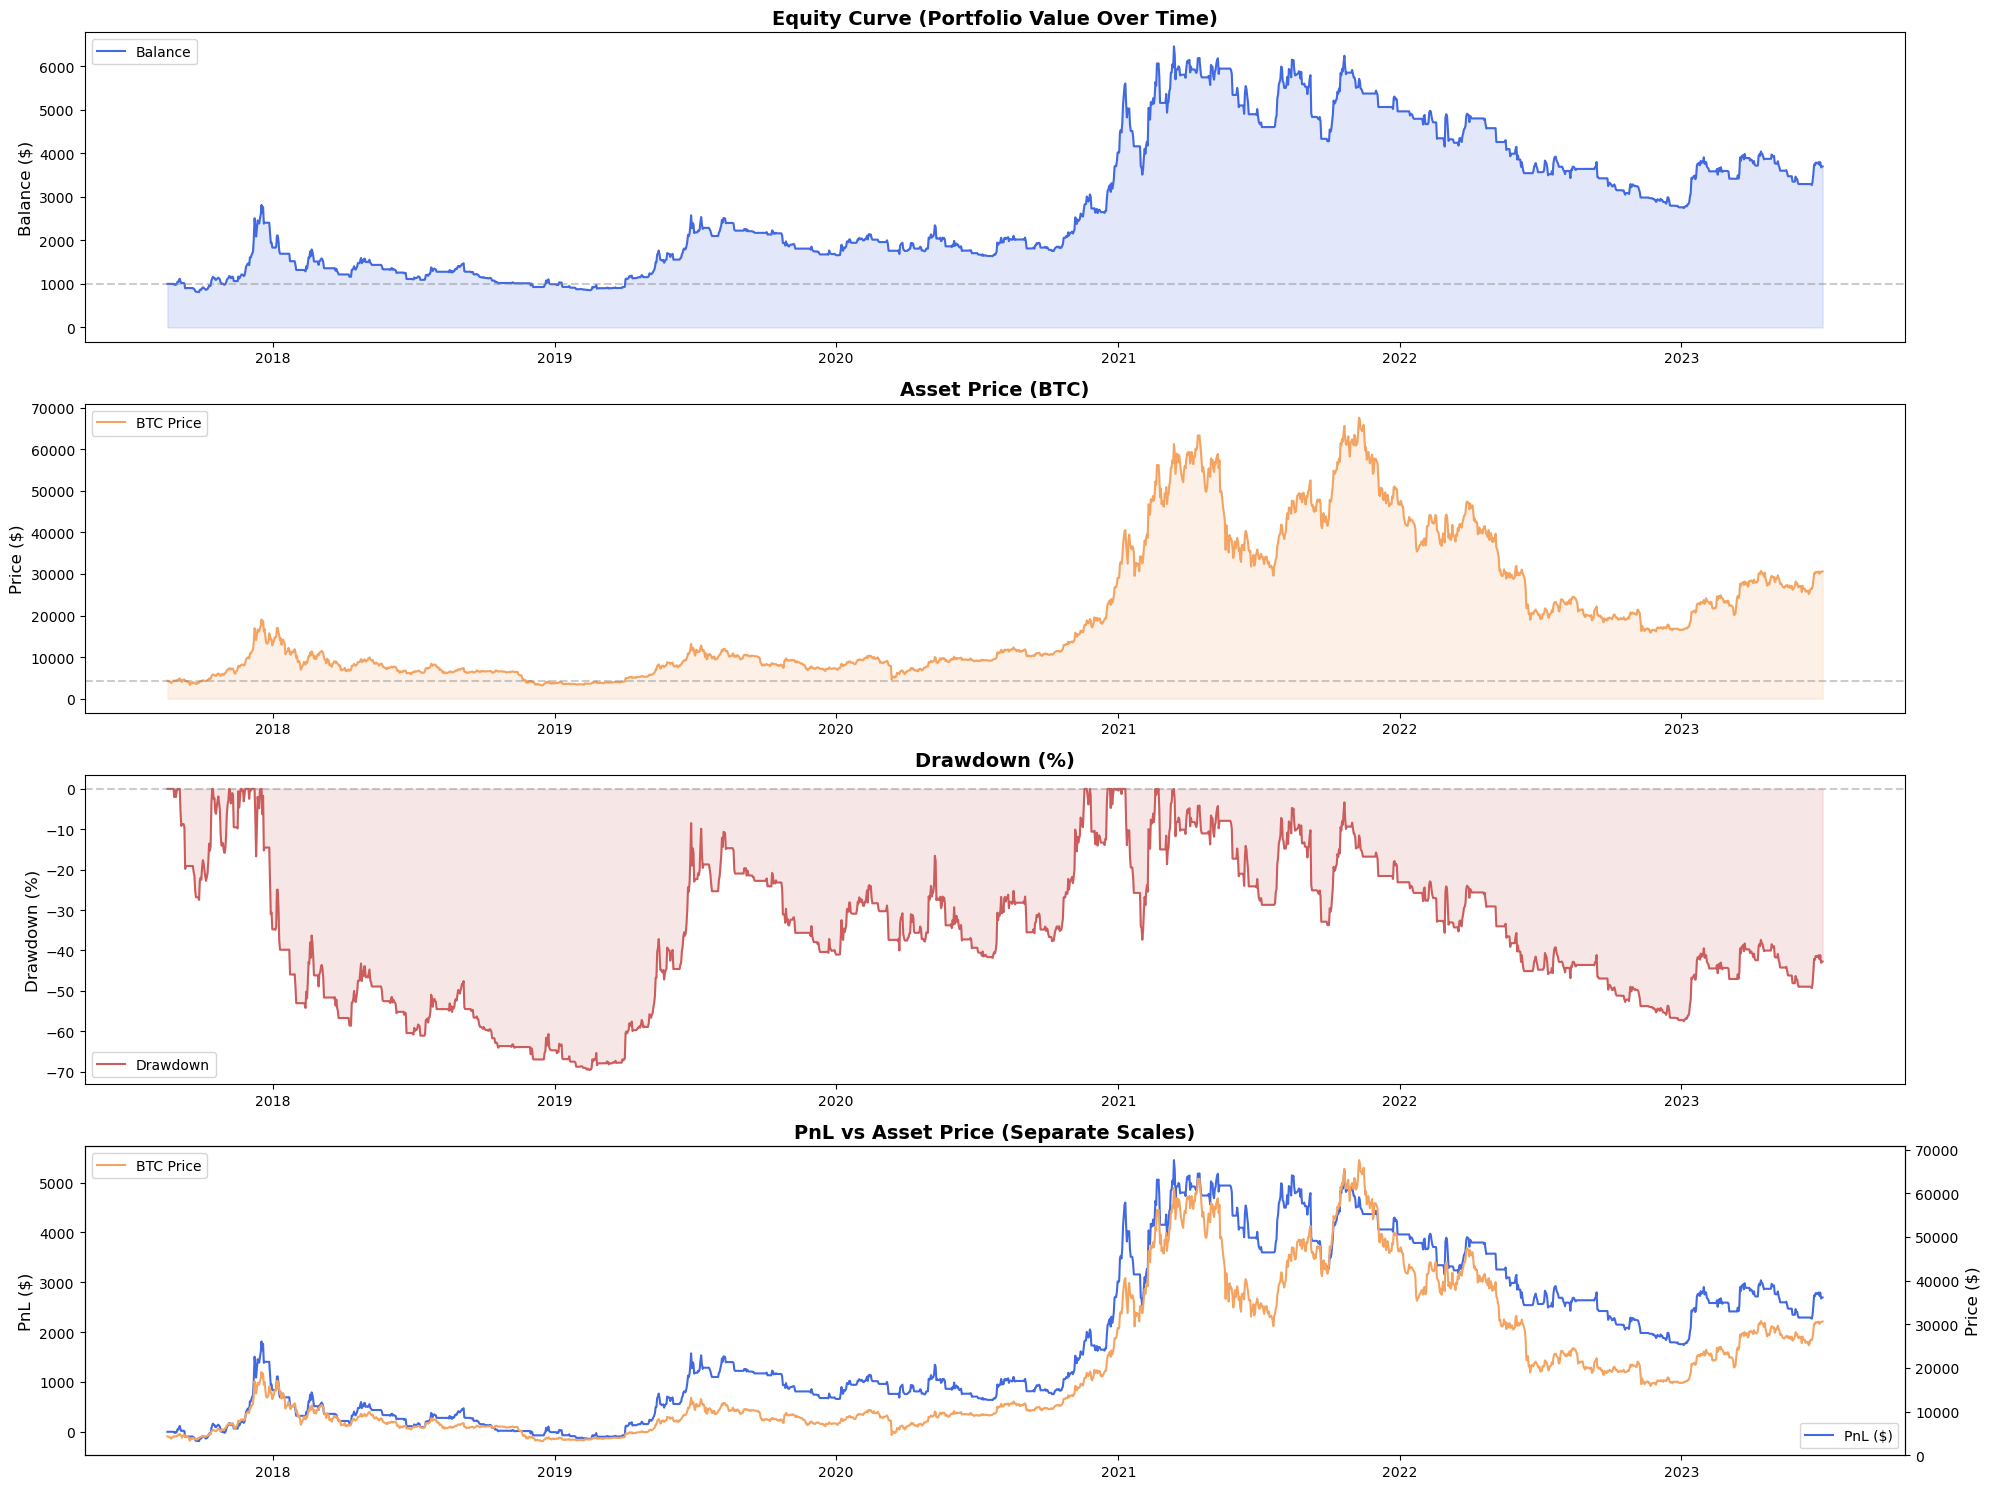

In [ ]:
bt = BacktestCrossMA()
bt.load_data("/Users/tusharbhatt/Desktop/Python for Finance/BTC-USDT.csv")
bt.populate_indicators()
bt.populate_signals()
bt.run_backtest()

bt.backtest_analaysis()    
bt.plot_equity_vs_asset()
